In [108]:
%%HTML

<h1>1. Abstract</h1>
<hr>
<h3>
    <p>In this HR analytics problem, we try to understand what causes the employees of a big company to leave prematurely, and come up with predictive models that predict which employees will leave next.  With the help of actionable insights and accurate predictions, companies can take steps to ensure that their talent is happy and engaged and can rethink their retention strategies to keep employees from leaving.</p>
</h3>

<h3>
    <p>Based on our analysis, we found that the Random Forests model outperformed all the other models in terms of predictive accuracy and AUC score. It is a model that is built based on the technique of ensemble learning, where several base estimators are built independently and their predictions are averaged. This helps reduce the variance and improves the generalizability and robustness over a single estimator. Furthermore, we obtain an importance score for each of the features used in the classification process which will help in interpreting the model's results. In our case, the model gave a lot of weight to Satisfaction Level, Time Spent at the Company, and Number of Projects. These attributes are quite obvious and therefore we feel confident in the predictions of this model.
</h3>

In [103]:
%%HTML
<h3>
    <p>We'll start by loading in all the required packages and defining a few helper functions that we'll use later on while performing machine learning.</p>
</h3>

In [8]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division

from sklearn import svm
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve, learning_curve

import seaborn as sns
#sns.set(style="white", context="talk")
sns.set(style="whitegrid")

from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

In [2]:
# Some helper functions for performing machine learning

def classify(grid, X_train, y_train, X_test, y_test):
    results = dict()
    
    #Training the model using grid search & cross validation
    start_time = time.time()
    grid.fit(X_train, y_train)
    end_time = time.time() - start_time
    results['training_time'] = end_time
    
    
    #Testing the model on the held out test data set
    start_time = time.time()
    grid_test = grid.predict(X_test)
    end_time = time.time() - start_time
    results['testing_time'] = end_time
    
    results['accuracy'] = metrics.accuracy_score(y_test, grid_test)
    results['report'] = metrics.classification_report(y_test, grid_test)
    results['matrix'] = metrics.confusion_matrix(y_test, grid_test)
    
    results['grid'] = grid
    results['grid_test'] = grid_test
    
    return(results)

def get_feature_importances(grid, X_test):
    #Returns a dataframe with feature importance info
    ls = list()
    for a,b in enumerate(grid.best_estimator_.feature_importances_):
        ls.append({'feature':X_test.columns[a], 'importance':b})
    feature_importances = pd.DataFrame(ls).sort_values(by = ['importance'], ascending=False)
    return(feature_importances)

def plot_feature_importances(feature_importances):
    ax = sns.stripplot(x = "importance", y = "feature", data = feature_importances)
    ax.set(xlabel = 'Importance', ylabel='Feature')
    return(ax)

def plot_validation_curve(model, X, y, items):
    train_scores, test_scores = validation_curve(model,
                                                 X,
                                                 y,
                                                 param_name=items['param_name'],
                                                 param_range=items['param_range'],
                                                 cv=10, 
                                                 scoring=items['scoring'],
                                                 n_jobs=-1)
    
    train_score_means = np.mean(train_scores, axis=1)
    test_score_means = np.mean(test_scores, axis=1)

    plt.title(items['title'])
    plt.xlabel(items['param_name'])
    plt.ylabel(items['scoring'])
    plt.ylim(0.0, 1.0)
    plt.plot(items['param_range'], train_score_means, color="darkorange", label="Training Score")
    plt.plot(items['param_range'], test_score_means, color="navy", label="Testing Score")
    plt.legend(loc="best")
    
    return(plt)


def plot_learning_curve(model, X, y, items):
    train_sizes_abs, train_scores, test_scores = learning_curve(model,
                                                                X,
                                                                y,
                                                                train_sizes=items['train_sizes'],
                                                                cv=items['cv'],
                                                                n_jobs=1)
    
    train_score_means = np.mean(train_scores, axis=1)
    test_score_means = np.mean(test_scores, axis=1)

    plt.title(items['title'])
    plt.xlabel('train_sizes')
    plt.ylabel(items['scoring'])
    plt.ylim(0.0, 1.0)
    plt.plot(train_sizes_abs, train_score_means, color="darkorange", label="Training Score")
    plt.plot(train_sizes_abs, test_score_means, color="navy", label="Testing Score")
    plt.legend(loc="best")
    
    return(plt)

def plot_roc_curve(items):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(items['y_test'], items['y_pred'])
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.title(items['title'])
    plt.plot(false_positive_rate, true_positive_rate, "b", label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return(plt)

def print_results(results):
    print "Best Estimator: \n\n%s"%(results['grid'].best_estimator_)
    print "\nTraining Time: \n\n%s seconds"%(results['training_time'])
    print "\nTesting Time: \n\n%s seconds"%(results['testing_time'])
    print "\nAccuracy: \n\n%s"%(results['accuracy'])
    print "\nConfusion Matrix: \n\n%s"%(results['matrix'])
    print "\nClassification Report: \n\n%s"%(results['report'])

In [102]:
%%HTML

<h1>2. Data Exploration</h1>
<hr>
<h3>
    <p>Lets first explore this dataset, which was obtained from <a href="https://www.kaggle.com/ludobenistant/hr-analytics">Kaggle.</a></p>

    <p>In our dataset we have the records of approximately 15,000 employees with information on attributes such as “Satisfaction Level”, “Salary”, “Department”, and “Average Monthly Hours”, to name a few. The target variable is “Sales”, a binary variable that tells us if an employee has quit or is still working for the company.</p>
</h3>

In [3]:
#Reading in the data
df = pd.read_csv("/Users/nandu/desktop/WORK/kaggle/hr/data/HR_comma_sep.csv")

print df.shape

print df.info()

(14999, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


In [101]:
%%HTML
<h3>
    <p>Lets get a quick look at some high level stats about our dataset.</p> 
    <p>We can see that the median satisfaction level is about 61% and on average employees work for upto 200 hours a month.</p>
</h3>

In [5]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [100]:
%%HTML
<h3>
    <p>The column “sales” represents the department to which the employees belong.</p>
    <p>Lets go ahead and change the column name to something more intuitive, and find out how many departments are there.</p>
</h3>

In [6]:
print pd.unique(df.sales.ravel())

['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


In [192]:
# We'll rename the "sales" column to "department".

df.rename(columns={"sales":"department"}, inplace=True)

In [99]:
%%HTML
<h3>
    <p>We can see that there are over 4000 employees belonging to the sales department and they constitute the majority in the workforce.
</h3>

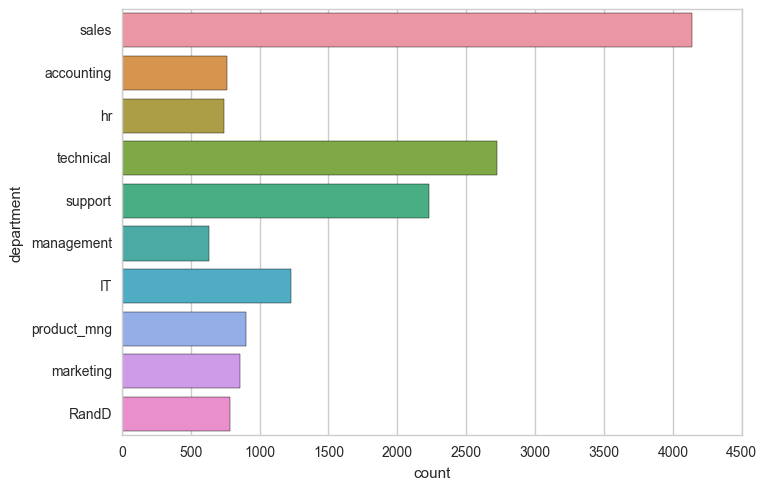

In [100]:
ax = None
ax = sns.countplot(y="department", data=df)
sns.plt.show()

In [98]:
%%HTML
<h3>
    <p>What are the average monthly hours for different salary groups? Lets find out by comparing the employees who have left with those who haven't.</p>
    <p>From the plot below we can see that the mean average monthly hour is 200 hours and is almost consistent across all groups.</p>
    <p>Former employees with low and medium salaries seem to have put in slightly more hours a month than everyone else and former employees with high salaries worked slightly less hours.</p>
</h3>

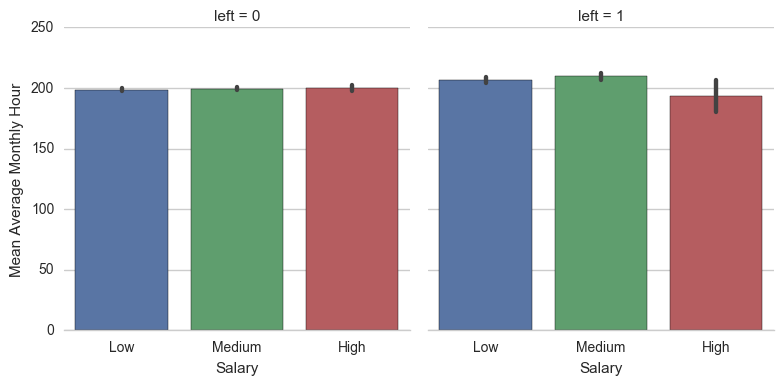

In [39]:
ax = None
ax = sns.factorplot(data=df, x="salary", y="average_montly_hours", col="left", kind="bar")
(ax
 .set_axis_labels("Salary", "Mean Average Monthly Hour")
 .set_xticklabels(["Low", "Medium", "High"])
 .despine(left=True, right=True))
sns.plt.show()

In [97]:
%%HTML
<h3>
    <p>What scores do employees get on their performance reviews? Is it the same across the different salary groups?</p>
    <p>The plot below answers these questions for us. We can see that the employees of different salary groups who've stayed have similar average performance scores and they're all well above 70%.</p>
    <p>Its interesting to note that the Low and Medium salaried employees who've left held an average performance score above 70%, but the scores of High salaried employees fall well below 70%.</p> 
<h3>

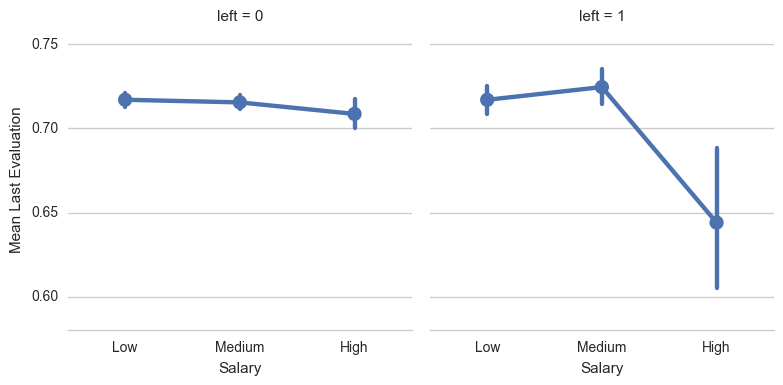

In [40]:
ax = None
ax = sns.factorplot(data=df, x="salary", y="last_evaluation", col="left", kind="point")
(ax
 .set_axis_labels("Salary", "Mean Last Evaluation")
 .set_xticklabels(["Low", "Medium", "High"])
 .despine(left=True, right=True))
sns.plt.show()

In [96]:
%%HTML
<h3>
    <p>We wish to find out if satisfaction levels play a role in employees leaving their companies. Lets find out what the distribution looks like in this dataset.</p>
    <p>It appears that the employees who have left have lower average satisfaction levels, ranging from a little over 0.37 to 0.46. Employees who stayed possess relatively higher satisfaction levels.</p>
<h3>

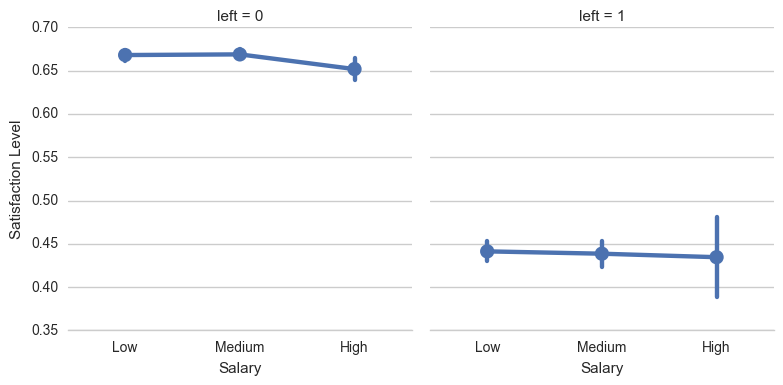

In [99]:
ax = None
ax = sns.factorplot(data=df, x="salary", y="satisfaction_level", col="left")
(ax
 .set_axis_labels("Salary", "Satisfaction Level")
 .set_xticklabels(["Low", "Medium", "High"])
 .despine(left=True, right=True))
sns.plt.show()

In [95]:
%%HTML
<h3>
    <p>Does the satisfaction level of the employees depend on how many projects they've been assigned to in a year?
    As it turns out, it does.</p> 
    <p>It appears that the people who are most satisfied with their jobs are assigned around 2 to 4 projects a year, and this satisfaction level is almost consistent across different salary groups. 
    Employees who are assigned to just 1 or even more than 4 projects have relatively lower satisfaction levels.</p>
</h3>

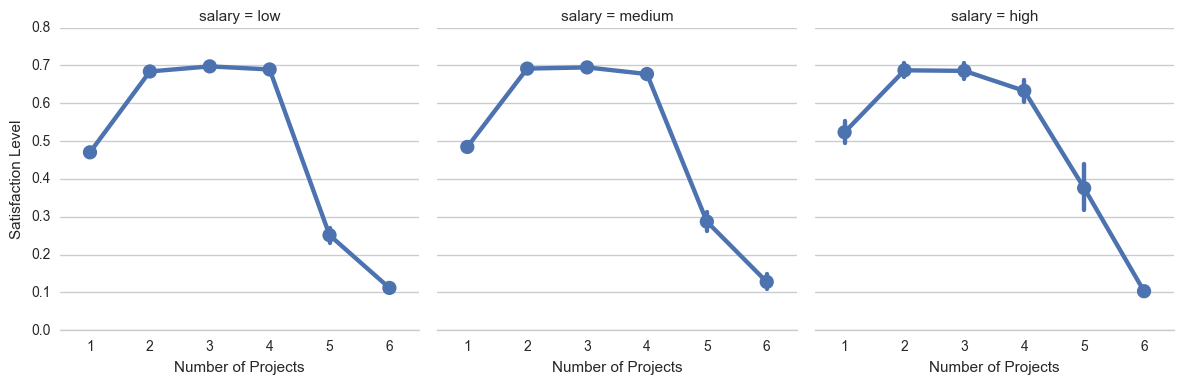

In [20]:
ax = None
ax = sns.factorplot(data=df, x="number_project", y="satisfaction_level", col="salary")
(ax
 .set_axis_labels("Number of Projects", "Satisfaction Level")
 .set_xticklabels([1, 2, 3, 4, 5, 6, 7])
 .despine(left=True, right=True))
sns.plt.show()

In [94]:
%%HTML
<h1>3. Predictive Modelling</h1>
<hr>

<h3>
    <p>In this section we'll develop supervised classification models that will predict whether a given employee will or won't leave the company.</p>
    <p>Before we go on to develop those models, we'll have to do a bit of data preprocessing.</p>
    <p>The columns "salary" and "department" are both categorical and will need to be encoded as binary variables. We perform One Hot Encoding to obtain their binary representations.</p>
</h3>

In [26]:
print pd.unique(df.salary.ravel())
print pd.unique(df.department.ravel())

['low' 'medium' 'high']
['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


In [27]:
#One hot encoding - Transforming all the categorical variables to their binary representations
salary = pd.get_dummies(df['salary'], drop_first=False)
department = pd.get_dummies(df['department'], drop_first=False)
df.drop(['salary', 'department'], axis=1, inplace=True)
df = pd.concat([df, salary, department], axis=1)

print df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 21 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
high                     14999 non-null uint8
low                      14999 non-null uint8
medium                   14999 non-null uint8
IT                       14999 non-null uint8
RandD                    14999 non-null uint8
accounting               14999 non-null uint8
hr                       14999 non-null uint8
management               14999 non-null uint8
marketing                14999 non-null uint8
product_mng              14999 non-null uint8
sales                    14999 non-null uint8
support      

In [93]:
%%HTML
<h3>
    <p>The plot below shows us how the class label "left" is distributed. We see that the vast majority of data points belong to class 0, the label which represents the employees who have not left the company.</p>
    <p>The remaining belong to class 1, the label which indicates that they have left.</p>
<h3>

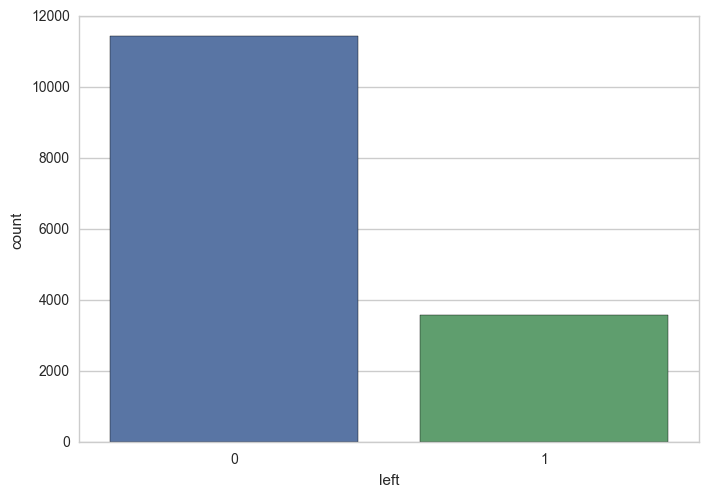

In [21]:
ax = None
ax = sns.countplot(x="left", data=df)
sns.plt.show()

In [92]:
%%HTML
<h3>
    <p>Since the dataset is imbalanced and skewed towards class 0, we'll use stratified sampling to construct our training and test data sets.</p>
    <p>Stratified sampling ensures that the percentage of both the classes remains consistent across the training and test sets.</p>
</h3>

In [32]:
train, test = train_test_split(df, test_size = 0.3, random_state = 5, stratify = df['left'])
X_train = train.ix[:, df.columns.difference(['left'])]
y_train = train.ix[:, 'left']
X_test = test.ix[:, df.columns.difference(['left'])]
y_test = test.ix[:, ['left']]

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(10499, 20) (10499,)
(4500, 20) (4500, 1)


In [91]:
%%HTML
<h3>
    <p>We'll use four different classification algorithms to develop the predictive models and find out which one performs the best.</p>
    <p>Lets start with the Random Forests algorithm, which works by building several decision trees and averaging their results.</p>
    <p>Apart from being highly interpretable, Decision Tree based modelling techniques also help us in understanding how important the features of a dataset are.</p>
</h3>

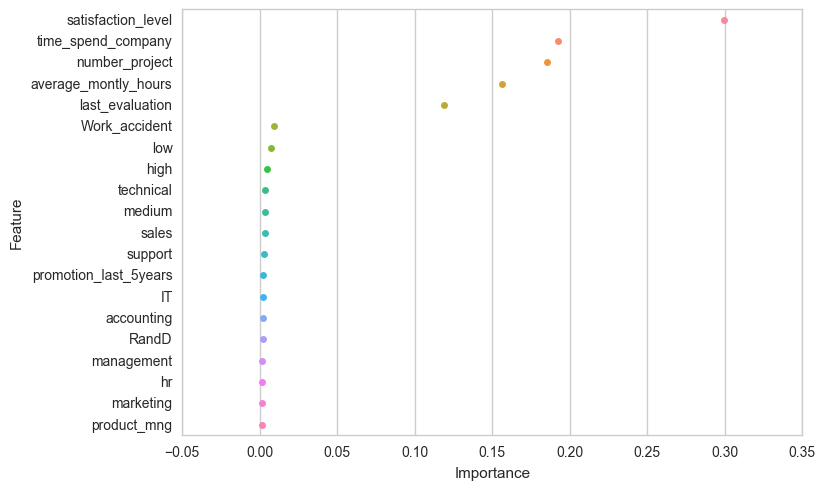

In [120]:
#Random Forests classification
n = range(1, 101)
param_grid = dict(n_estimators=n)

random_forests = RandomForestClassifier(random_state=5)
grid = GridSearchCV(random_forests, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

results1 = classify(grid, X_train, y_train, X_test, y_test)

#Visualizing the importance of the features
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
#It is also known as the Gini importance.

feature_importances = get_feature_importances(results1['grid'], X_test)

ax = None
ax = plot_feature_importances(feature_importances)
sns.plt.show()

In [90]:
%%HTML
<h3>
    <p>Our Random Forests model tells us that the feature "satisfaction_level" plays the most important role in determining the class of a tuple.</p>
    <p>The processing times and accuracy scores are shown below.</p>
</h3>

In [121]:
print_results(results1)

Best Estimator: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=95, n_jobs=1, oob_score=False, random_state=5,
            verbose=0, warm_start=False)

Training Time: 

370.511821032 seconds

Testing Time: 

0.147028923035 seconds

Accuracy: 

0.989111111111

Confusion Matrix: 

[[3417   12]
 [  37 1034]]

Classification Report: 

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3429
          1       0.99      0.97      0.98      1071

avg / total       0.99      0.99      0.99      4500



In [89]:
%%HTML
<h3>
    <p>Lets drop the features with relatively lower scores, generate new train/test sets,and retrain the RF model to see if there are any changes in the accuracy.</p>
<h3>

In [122]:
top_features = feature_importances[:5]['feature'].tolist() + ['left']
new_df = df[top_features]

train, test = train_test_split(new_df, test_size = 0.3, random_state = 5, stratify = new_df['left'])
X_train = train.ix[:, new_df.columns.difference(['left'])]
y_train = train.ix[:, 'left']
X_test = test.ix[:, new_df.columns.difference(['left'])]
y_test = test.ix[:, ['left']]

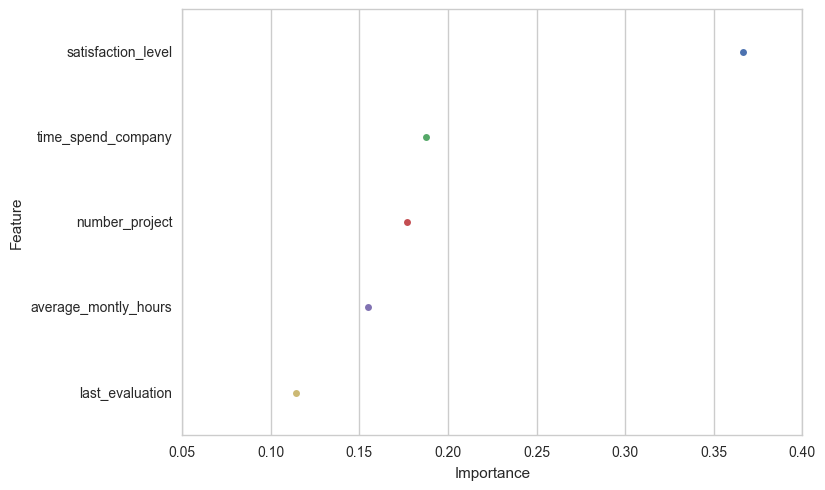

In [138]:
#Random Forests classification with reduced features
n = range(1, 101)
param_grid = dict(n_estimators=n)

random_forests = RandomForestClassifier(random_state=5)
grid = GridSearchCV(random_forests, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

results1 = classify(grid, X_train, y_train, X_test, y_test)

feature_importances = get_feature_importances(results1['grid'], X_test)

ax = None
ax = plot_feature_importances(feature_importances)
sns.plt.show()

In [88]:
%%HTML
<h3>
    <p>We can see that reducing the number of features hasn't affected the overall scores.</p>
    <p>Although the model takes quite a while to train, it produces pretty impressive class precision and recall scores.</p>
</h3>

In [139]:
print_results(results1)

Best Estimator: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=91, n_jobs=1, oob_score=False, random_state=5,
            verbose=0, warm_start=False)

Training Time: 

370.231522083 seconds

Testing Time: 

0.213017940521 seconds

Accuracy: 

0.99

Confusion Matrix: 

[[3416   13]
 [  32 1039]]

Classification Report: 

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3429
          1       0.99      0.97      0.98      1071

avg / total       0.99      0.99      0.99      4500



In [87]:
%%HTML
<h3>
    <p>Lets take a look at what the ROC curve looks like for our Random Forests model.</p>
    <p>The ROC curve is a plot of the False Positive Rate vs the True Positive Rate of a binary classifier.</p>
    <p>AUC, which stands for Area Under the Curve, tells us what the value of the area under the curve is.</p> 
    <p>The closer AUC is to 1.0, the better our model is at performing classifications.</p>
<h3>

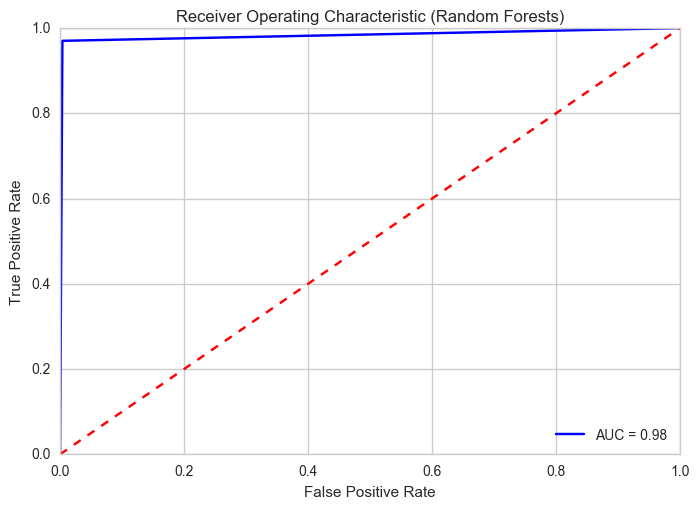

In [157]:
items = {"title":"Receiver Operating Characteristic (Random Forests)", 
         "y_test":y_test, 
         "y_pred":results1['grid_test']}

plt = plot_roc_curve(items)
plt.show()

In [86]:
%%HTML
<h3>
    <p>Validation curves help us visualize how the performance of our model during training and testing varies with changes in its hyperparameter values.</p>
</h3>

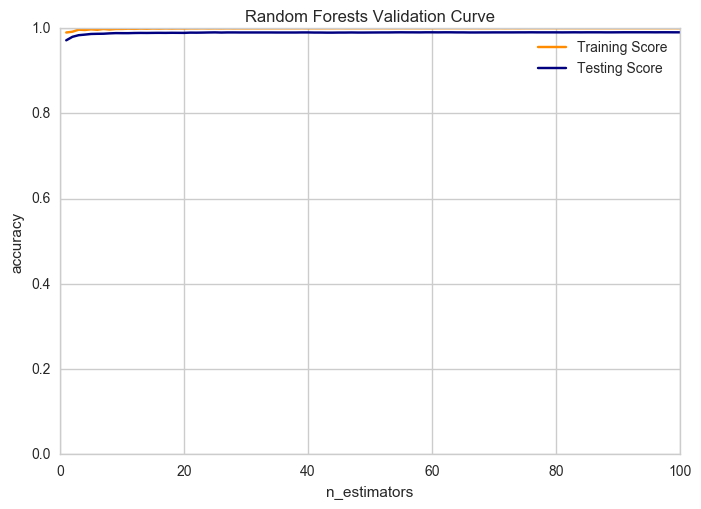

In [125]:
#Random Forests Validation Curve 

random_forests_classifier = RandomForestClassifier(random_state=5)
n_estimators = range(1, 101)

items = {'title':'Random Forests Validation Curve',
         'param_range':n_estimators,
         'param_name':'n_estimators',
         'scoring':'accuracy'}

plt = plot_validation_curve(random_forests_classifier, X_train, y_train, items)
plt.show()

In [85]:
%%HTML
<h3>
    <p>Learning curves help us visualize how the performance of our model during training and testing varies with changes in the training set size.</p>
</h3>

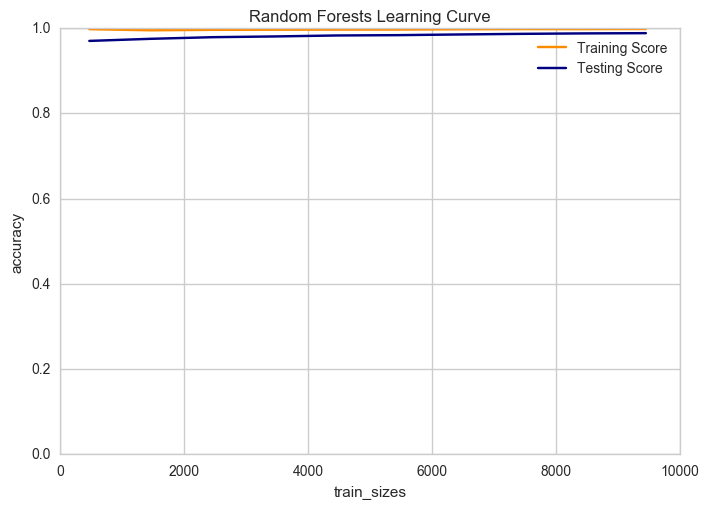

In [137]:
#Random Forests Learning Curve

random_forests_classifier = RandomForestClassifier(random_state=5, n_estimators=10)
train_sizes = np.linspace(.05, 1.0, 10)

items = {'title':'Random Forests Learning Curve',
         'train_sizes':train_sizes,
         'cv':10,
         'scoring':'accuracy'}

plt = plot_learning_curve(random_forests_classifier, X_train, y_train, items)
plt.show()

In [84]:
%%HTML
<h3>
    <p>We'll now develop prediction models using SVM, K Nearest Neighbors, and a standard Decision Tree, and also generate ROC, learning and validation curves for each of the models to find out how they perform.</p>
</h3>

In [155]:
#SVM Classification
kernel = ['sigmoid', 'rbf']
param_grid = dict(kernel=kernel)

support_vector_classifier = svm.SVC(random_state=5)
grid = GridSearchCV(support_vector_classifier, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

results2 = classify(grid, X_train, y_train, X_test, y_test)

print_results(results2)

Best Estimator: 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=5, shrinking=True,
  tol=0.001, verbose=False)

Training Time: 

18.4784369469 seconds

Testing Time: 

0.27725982666 seconds

Accuracy: 

0.955111111111

Confusion Matrix: 

[[3308  121]
 [  81  990]]

Classification Report: 

             precision    recall  f1-score   support

          0       0.98      0.96      0.97      3429
          1       0.89      0.92      0.91      1071

avg / total       0.96      0.96      0.96      4500



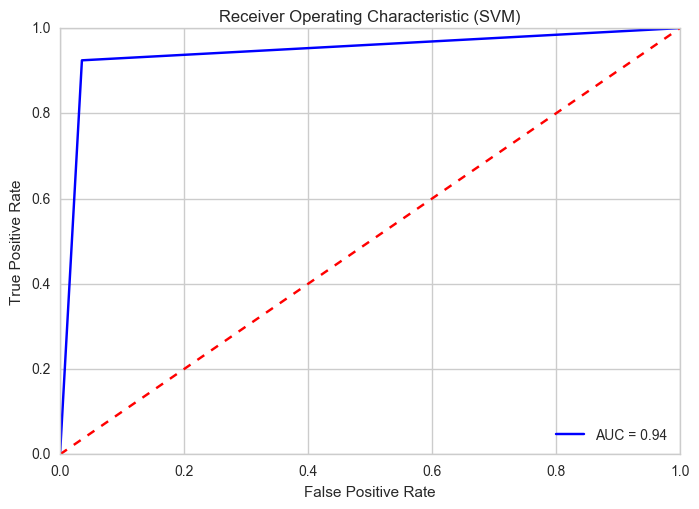

In [159]:
#ROC Curve for SVM

items = {"title":"Receiver Operating Characteristic (SVM)", 
         "y_test":y_test, 
         "y_pred":results2['grid_test']}

plt = plot_roc_curve(items)
plt.show()

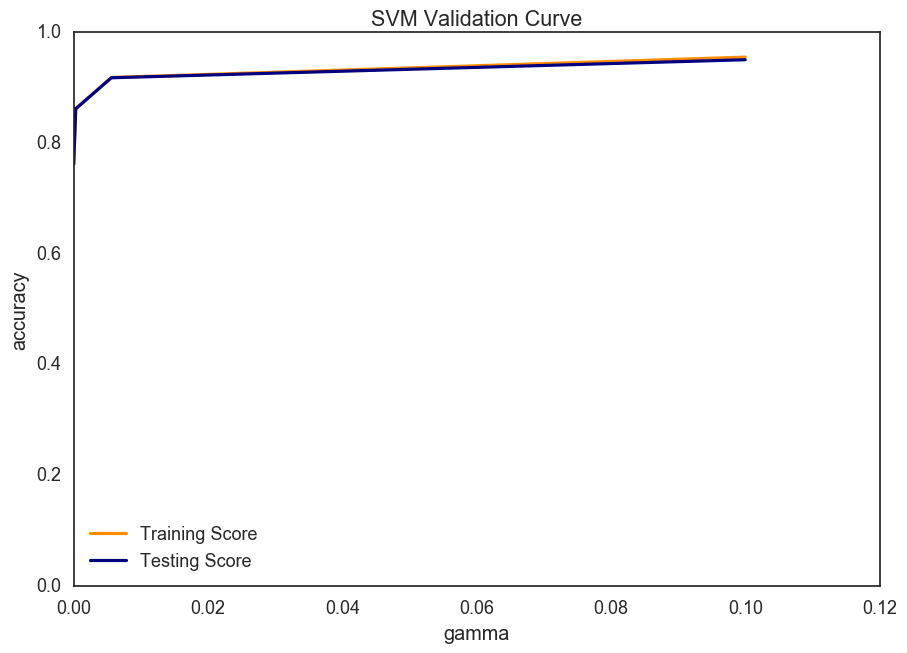

In [132]:
#SVM Validation Curve

support_vector_classifier = svm.SVC(random_state=5, kernel="rbf")
gamma = np.logspace(-6, -1, 5)

items = {'title':'SVM Validation Curve',
         'param_range':gamma,
         'param_name':'gamma',
         'scoring':'accuracy'}

plt = plot_validation_curve(support_vector_classifier, X_train, y_train, items)
plt.show()

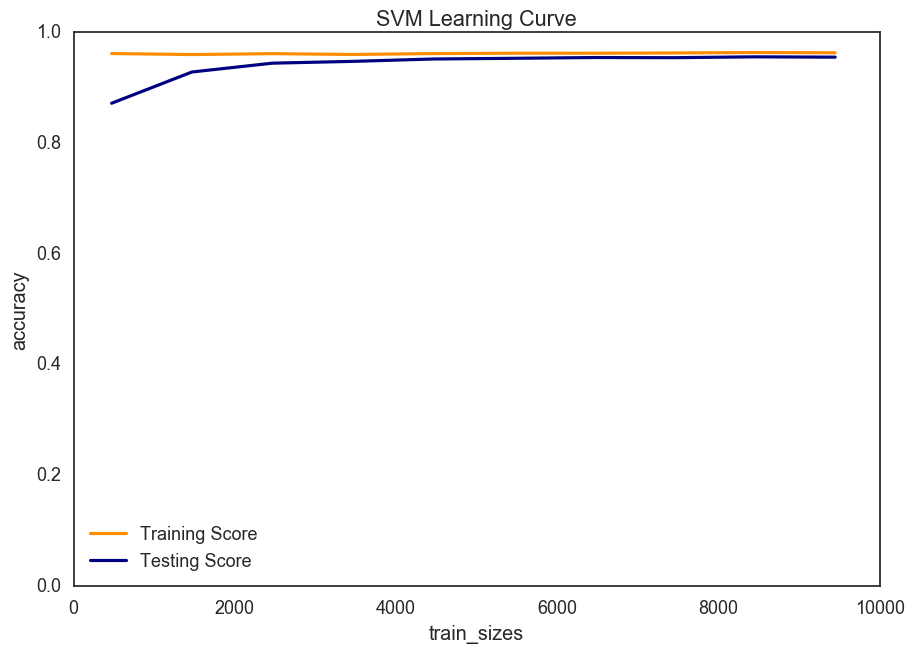

In [133]:
#SVM Learning Curve

support_vector_classifier = svm.SVC(random_state=5, kernel="rbf")
train_sizes = np.linspace(.05, 1.0, 10)

items = {'title':'SVM Learning Curve',
         'train_sizes':train_sizes,
         'cv':10,
         'scoring':'accuracy'}

plt = plot_learning_curve(support_vector_classifier, X_train, y_train, items)
plt.show()

In [161]:
#KNN Classification
p = range(1, 3)
n_neighbors = range(1, 101)
param_grid = dict(p=p, n_neighbors=n_neighbors)

knn_classifier = KNeighborsClassifier()
grid = GridSearchCV(knn_classifier, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

results3 = classify(grid, X_train, y_train, X_test, y_test)

print_results(results3)

Best Estimator: 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform')

Training Time: 

217.44519496 seconds

Testing Time: 

0.0237970352173 seconds

Accuracy: 

0.965111111111

Confusion Matrix: 

[[3313  116]
 [  41 1030]]

Classification Report: 

             precision    recall  f1-score   support

          0       0.99      0.97      0.98      3429
          1       0.90      0.96      0.93      1071

avg / total       0.97      0.97      0.97      4500



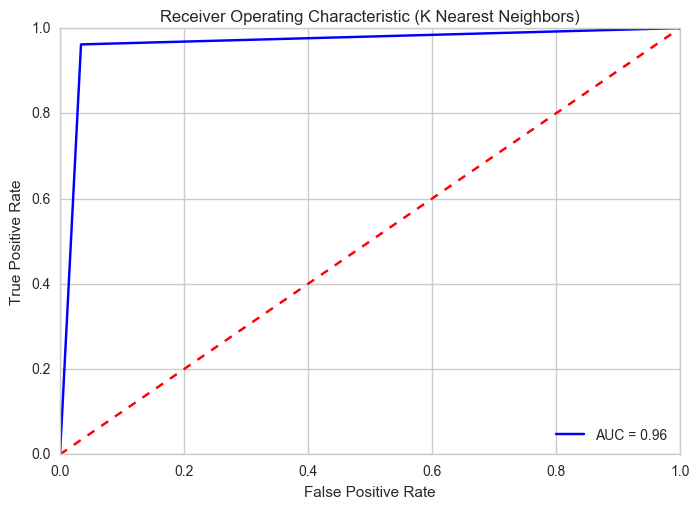

In [162]:
items = {"title":"Receiver Operating Characteristic (K Nearest Neighbors)", 
         "y_test":y_test, 
         "y_pred":results3['grid_test']}

plt = plot_roc_curve(items)
plt.show()

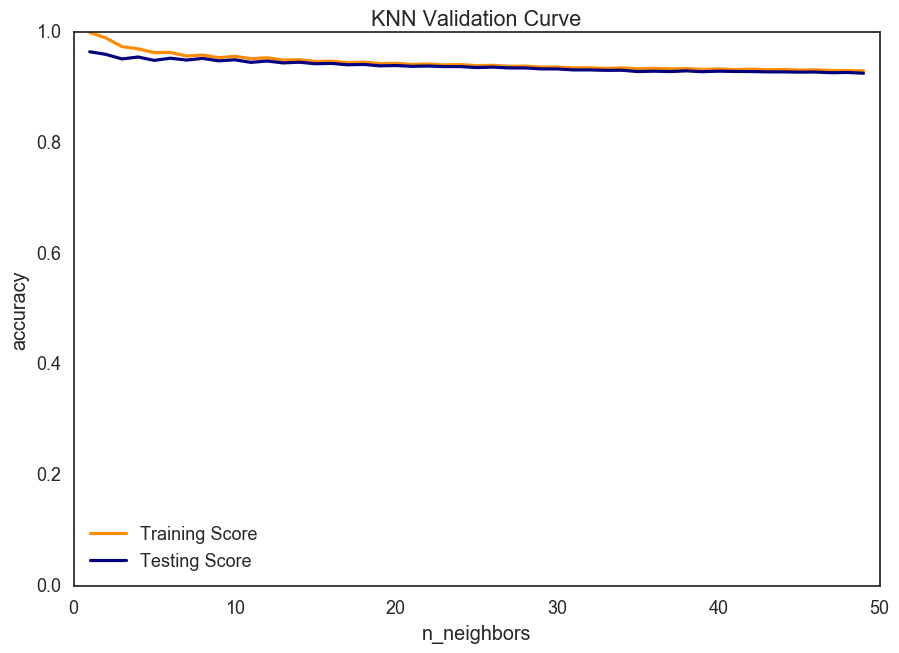

In [134]:
#KNN Validation curve

knn_classifier = KNeighborsClassifier()
n_neighbors = range(1, 50)

items = {'title':'KNN Validation Curve',
         'param_range':n_neighbors,
         'param_name':'n_neighbors',
         'scoring':'accuracy'}

plt = plot_validation_curve(knn_classifier, X_train, y_train, items)
plt.show()

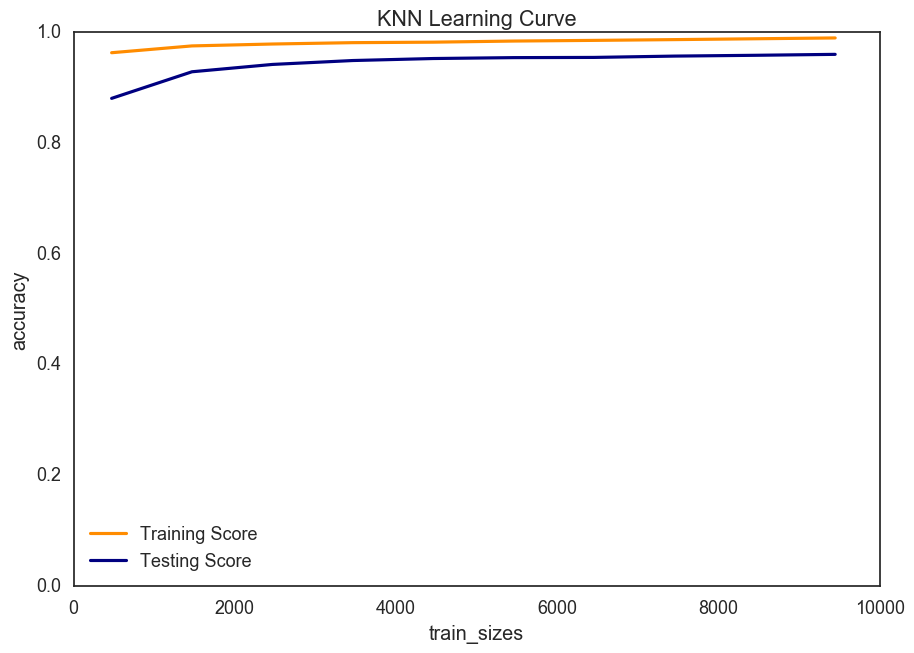

In [135]:
#KNN Learning curve

knn_classifier = KNeighborsClassifier(n_neighbors=2)
train_sizes = np.linspace(.05, 1.0, 10)

items = {'title':'KNN Learning Curve',
         'train_sizes':train_sizes,
         'cv':10,
         'scoring':'accuracy'}

plt = plot_learning_curve(knn_classifier, X_train, y_train, items)
plt.show()

In [163]:
#Decision Tree Classifier

max_depth = range(10, 31)
param_grid = dict(max_depth=max_depth)
decision_tree_classifier = DecisionTreeClassifier(random_state=5)
grid = GridSearchCV(decision_tree_classifier, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
results4 = classify(grid, X_train, y_train, X_test, y_test)
print_results(results4)

Best Estimator: 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=5, splitter='best')

Training Time: 

4.46342611313 seconds

Testing Time: 

0.000945091247559 seconds

Accuracy: 

0.979555555556

Confusion Matrix: 

[[3391   38]
 [  54 1017]]

Classification Report: 

             precision    recall  f1-score   support

          0       0.98      0.99      0.99      3429
          1       0.96      0.95      0.96      1071

avg / total       0.98      0.98      0.98      4500



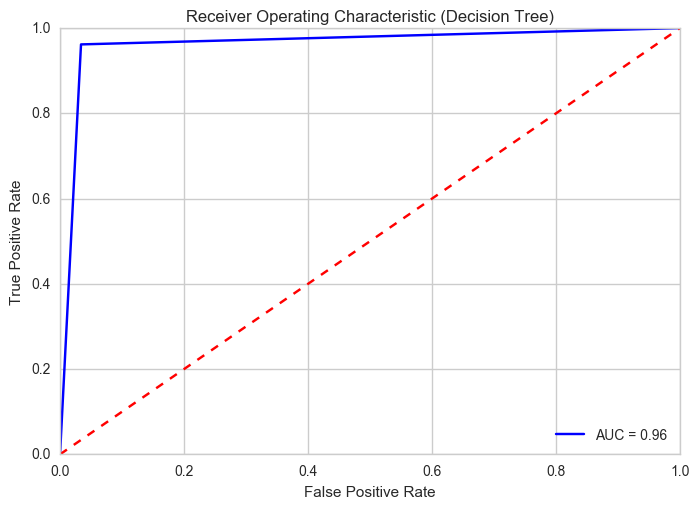

In [165]:
items = {"title":"Receiver Operating Characteristic (Decision Tree)", 
         "y_test":y_test, 
         "y_pred":results3['grid_test']}

plt = plot_roc_curve(items)
plt.show()

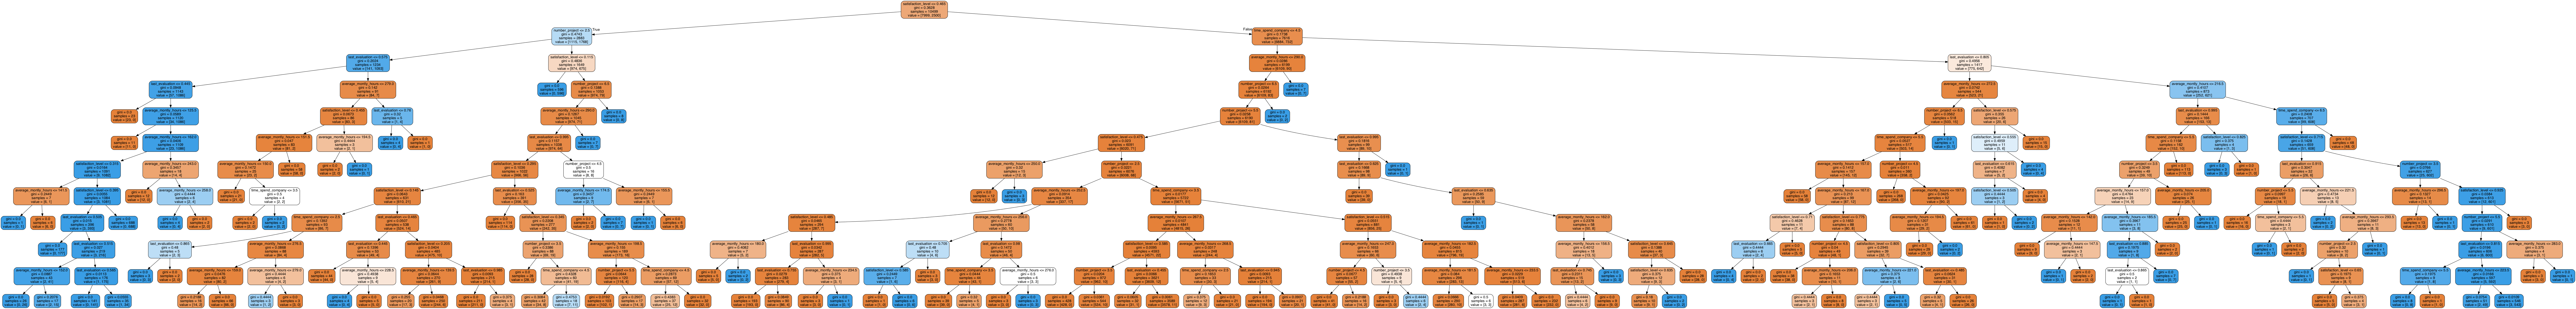

In [164]:
#Printing out the decision tree
my_tree = results4['grid'].best_estimator_
dot_data = export_graphviz(my_tree, out_file=None, feature_names=X_test.columns, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_pdf("/users/nandu/Desktop/tree.pdf")
Image(graph.create_png())

In [83]:
%%HTML
<h3>
    <p>Lets visualise the ROC curves of all our models together to find out which one performed the best.<p>
    <p>We can see that all the models performed well, but the Random Forests model performed the best, with an AUC score of 0.98.</p>
</h3>

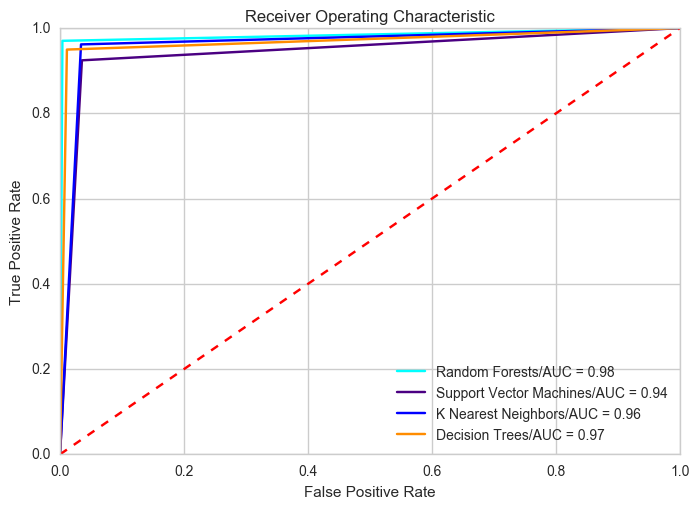

In [187]:
colors = ['cyan', 'indigo','blue', 'darkorange']
titles = ["Random Forests", "Support Vector Machines", "K Nearest Neighbors", "Decision Trees"]
results = [results1, results2, results3, results4]
models = zip(colors, results, titles)

for model in models:
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, model[1]['grid_test'])
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, model[0], label=model[2]+'/AUC = %0.2f'% roc_auc)

plt.plot([0,1],[0,1],'r--')
plt.title("Receiver Operating Characteristic")
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()